# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_initial_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 64  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 100     # number of hidden units
layers = 8      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(x_points): # x_points is N x dim
    """
    Computes the target function psi(x) = ||x||_2^2 for the given problem.
    """
    return euclid_norm_sq(x_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)



def evaluate_learned_J_HJ_approx(x_points, model):
    """
    Evaluates the learned prior J(x) using the method of characteristics
    for quadratic Hamiltonian H(p) = 0.5 * ||p||^2.
    
    The method of characteristics gives us:
    J(grad_psi(x)) = <x, grad_psi(x)> - 0.5 * ||grad_psi(x)||^2 - psi(x)
    
    To get J(x), we need to find the x' such that grad_psi(x') = x,
    then evaluate the formula at x'.
    
    For this specific problem where psi(x) = ||x||^2, we have grad_psi(x) = 2x,
    so to evaluate J(y), we need x = y/2.
    
    Args:
        x_points: numpy array of shape (N, dim) containing evaluation points
        model: trained LPN model
    
    Returns:
        J_est: numpy array of shape (N,) containing estimated J values
    """
    # To evaluate J(x), we need to find x' such that grad_psi(x') = x
    # For the learned psi approximating ||x||^2, grad_psi(x) ≈ 2x
    # So x' ≈ x/2 to get grad_psi(x') ≈ x
    
    # However, for a general learned model, we'd need to solve the inverse problem
    # For simplicity, assuming the model learned psi(x) ≈ ||x||^2 well,
    # we use the approximation x' = x/2
    
    x_prime = x_points / 2.0
    
    # Convert to tensor
    x_tensor = torch.from_numpy(x_prime).float().to(device)
    x_tensor.requires_grad_(True)
    
    # Get psi(x')
    psi_x = model.scalar(x_tensor)
    
    # Get gradient of psi at x'
    grad_psi = model(x_tensor)
    
    # Compute inner product <x', grad_psi(x')>
    inner_prod = torch.sum(x_tensor * grad_psi, dim=1, keepdim=True)
    
    # Compute ||grad_psi(x')||^2
    grad_psi_norm_sq = torch.sum(grad_psi * grad_psi, dim=1, keepdim=True)
    
    # Apply the formula: this gives J(grad_psi(x')) ≈ J(x)
    J_est = inner_prod - 0.5 * grad_psi_norm_sq - psi_x
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_psi_true = x1_0_psi_true
        x2_0_J_true = x1_0_J_true

    x1_0_psi_est = cvx(x1_0_points, model)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
    print(x1_0_J_est.shape)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"$\psi(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$\psi(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"$\psi(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$\psi(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)


<>:121: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:126: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:132: SyntaxWarning: invalid escape sequence '\p'
<>:134: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
<>:121: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:126: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:132: SyntaxWarning: invalid escape sequence '\p'
<>:134: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
/scratch/16122989/ipykernel_466082/3280289920.py:121: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")


In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
x_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(x_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

x_j_exp_tensor = torch.from_numpy(x_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: x_j_exp_tensor shape {x_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")


# --- ADD THIS TO MOVE DATA TO GPU ---
x_j_exp_tensor = x_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: x_j_exp_tensor shape torch.Size([20000, 64]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 117971.75


iteration 0 loss 699.6279907226562


iteration 5000 loss 371.5343933105469


iteration 10000 loss 170.91268920898438


iteration 15000 loss 1.6130151748657227


iteration 20000 loss 0.10942445695400238


iteration 25000 loss 0.062189050018787384


iteration 30000 loss 0.006665458437055349


iteration 35000 loss 0.0005108251934871078


iteration 40000 loss 0.0001415821461705491


iteration 45000 loss 6.818671681685373e-05


iteration 50000 loss 0.00011710288526955992


iteration 55000 loss 3.9792801544535905e-05


iteration 60000 loss 6.785119330743328e-05


iteration 65000 loss 3.85216590075288e-05


iteration 70000 loss 0.0001445351808797568


iteration 75000 loss 4.344652916188352e-05


iteration 80000 loss 4.772758620674722e-05


iteration 85000 loss 0.0008102821302600205


iteration 90000 loss 0.08550512790679932


iteration 95000 loss 4.0990213165059686e-05


iteration 100000 loss 6.195486639626324e-05


iteration 105000 loss 8.869325637817383


iteration 110000 loss 1.7635070085525513


iteration 115000 loss 0.010372759774327278


iteration 120000 loss 6.964558269828558e-05


iteration 125000 loss 5.642827454721555e-05


iteration 130000 loss 6.423141894629225e-05


iteration 135000 loss 0.0046765683218836784


iteration 140000 loss 0.25584185123443604


iteration 145000 loss 6.402726285159588e-05


iteration 150000 loss 4.386248838272877e-05


iteration 155000 loss 5.036667425883934e-05


iteration 160000 loss 5.521276034414768e-05


iteration 165000 loss 0.03790489584207535


iteration 170000 loss 5.1502072892617434e-05


iteration 175000 loss 0.002153061330318451


iteration 180000 loss 6.192160799400881e-05


iteration 185000 loss 4.4113287003710866e-05


iteration 190000 loss 4.529969010036439e-05


iteration 195000 loss 5.311465065460652e-05


iteration 200000 loss 8.360296487808228e-05


iteration 205000 loss 0.019390959292650223


iteration 210000 loss 5.008845619158819e-05


iteration 215000 loss 4.894327139481902e-05


iteration 220000 loss 4.578196967486292e-05


iteration 225000 loss 0.0015026758192107081


iteration 230000 loss 6.3795865571592e-05


iteration 235000 loss 0.008528124541044235


iteration 240000 loss 4.90261081722565e-05


iteration 245000 loss 4.3262902181595564e-05


iteration 250000 loss 0.000368601264199242


iteration 255000 loss 4.172030457993969e-05


iteration 260000 loss 0.010580514557659626


iteration 265000 loss 3.933188781957142e-05


iteration 270000 loss 2.3068418502807617


iteration 275000 loss 0.0010817721486091614


iteration 280000 loss 3.644942626124248e-05


iteration 285000 loss 0.30338382720947266


iteration 290000 loss 4.310316944611259e-05


iteration 295000 loss 4.2295130697311834e-05


iteration 300000 loss 3.6320314393378794e-05


iteration 305000 loss 0.005203833803534508


iteration 310000 loss 0.00019033736316487193


iteration 315000 loss 4.71511302748695e-05


iteration 320000 loss 0.043824829161167145


iteration 325000 loss 0.00011777137115132064


iteration 330000 loss 3.6308279959484935e-05


iteration 335000 loss 0.0003481399908196181


iteration 340000 loss 0.0009968089871108532


iteration 345000 loss 5.1923623686889187e-05


iteration 350000 loss 4.321774031268433e-05


iteration 355000 loss 3.2838332117535174e-05


iteration 360000 loss 4.3113617721246555e-05


iteration 365000 loss 0.003054616507142782


iteration 370000 loss 0.002355326898396015


iteration 375000 loss 0.000571876298636198


iteration 380000 loss 0.07039444148540497


iteration 385000 loss 0.027065331116318703


iteration 390000 loss 0.00024818783276714385


iteration 395000 loss 3.540301986504346e-05


iteration 400000 loss 6.733130430802703e-05


iteration 405000 loss 0.028333669528365135


iteration 410000 loss 3.5337405279278755e-05


iteration 415000 loss 3.465834379196167


iteration 420000 loss 4.041126885567792e-05


iteration 425000 loss 0.1398785412311554


iteration 430000 loss 4.093510870006867e-05


iteration 435000 loss 4.0002927562454715e-05


iteration 440000 loss 7.658785034436733e-05


iteration 445000 loss 8.045851707458496


iteration 450000 loss 3.4541306376922876e-05


iteration 455000 loss 3.351811756147072e-05


iteration 460000 loss 5.6064996897475794e-05


iteration 465000 loss 3.289585583843291e-05


iteration 470000 loss 3.9851656765677035e-05


iteration 475000 loss 0.39296218752861023


iteration 480000 loss 0.03945516422390938


iteration 485000 loss 0.09255235642194748


iteration 490000 loss 3.1750045309308916e-05


iteration 495000 loss 4.378650555736385e-05


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
(50,)


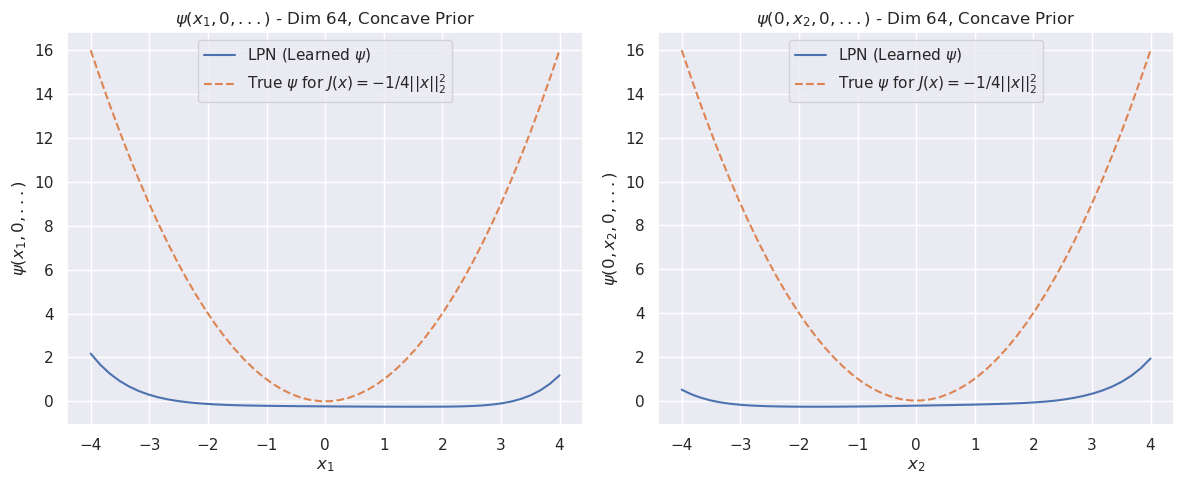

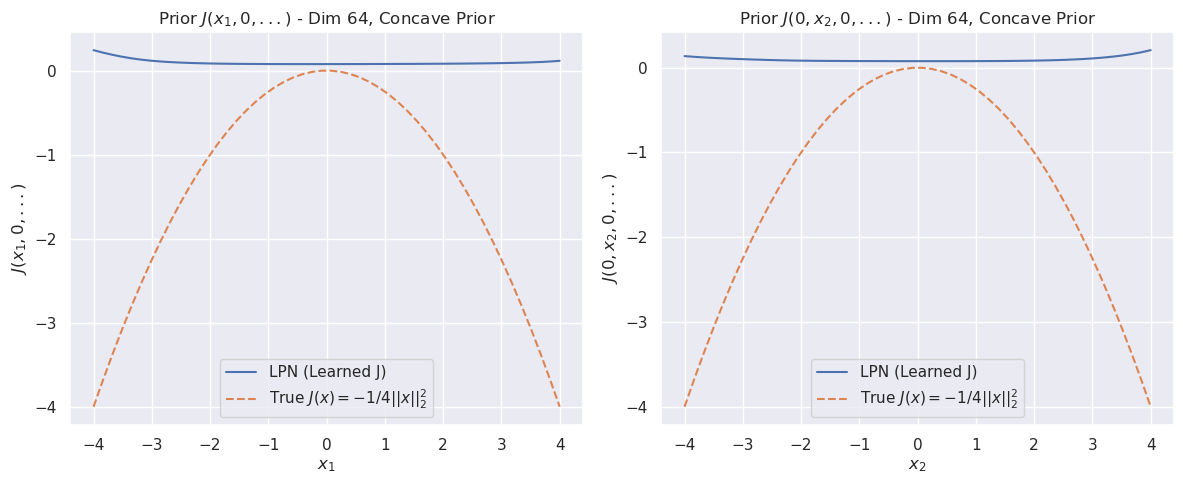

In [8]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad, a_exp, spacing, INVERT_MODE, dim_exp)
#evaluate_learned_H(lpn_model_concave_quad, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=64) ---


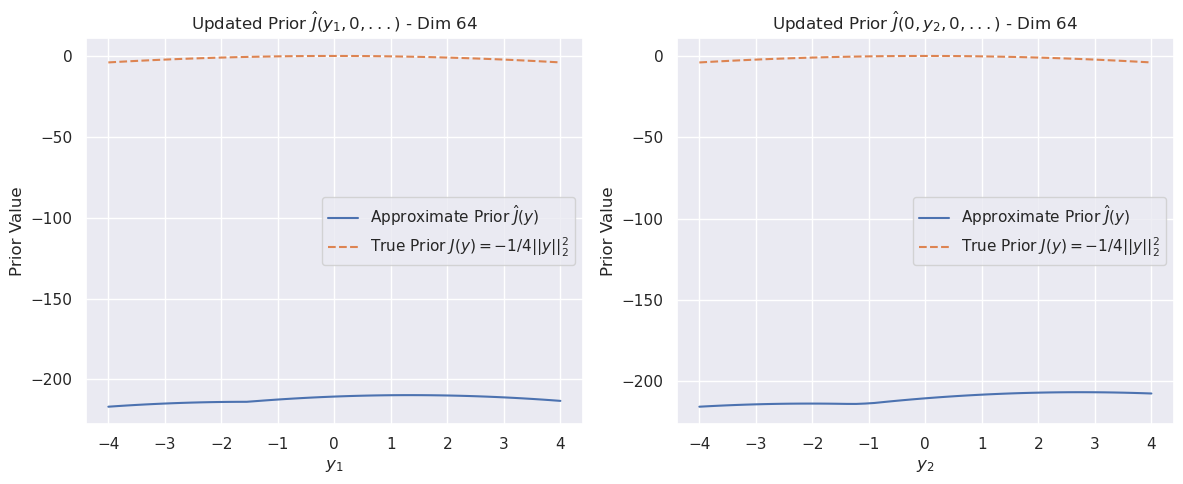

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = x_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = x_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad, a_exp, spacing, dim_exp, x_k_subset_np)


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 44702.62109375


iteration 0 loss 6853.333984375


iteration 5000 loss 107.651123046875


iteration 10000 loss 26.961339950561523


iteration 15000 loss 6.376885890960693


iteration 20000 loss 0.8166399002075195


iteration 25000 loss 0.2381710559129715


iteration 30000 loss 0.1065393015742302


iteration 35000 loss 0.05545097962021828


iteration 40000 loss 0.03156909719109535


iteration 45000 loss 3.7559452056884766


iteration 50000 loss 0.011630147695541382


iteration 55000 loss 0.007479145657271147


iteration 60000 loss 0.006459452677518129


iteration 65000 loss 2.062652587890625


iteration 70000 loss 0.0026013189926743507


iteration 75000 loss 0.0014755361480638385


iteration 80000 loss 0.0010274728992953897


iteration 85000 loss 2.496583938598633


iteration 90000 loss 0.0009783930145204067


iteration 95000 loss 0.0003764757711905986


iteration 100000 loss 0.00025877082953229547


iteration 105000 loss 0.00020048503938596696


iteration 110000 loss 0.02234618365764618


iteration 115000 loss 0.00010796218703035265


iteration 120000 loss 1.8336687088012695


iteration 125000 loss 7.341994205489755e-05


iteration 130000 loss 0.015754714608192444


iteration 135000 loss 4.9439786380389705e-05


iteration 140000 loss 0.10357335209846497


iteration 145000 loss 3.347038000356406e-05


iteration 150000 loss 3.224798274459317e-05


iteration 155000 loss 2.9309847377589904e-05


iteration 160000 loss 2.7212363420403562e-05


iteration 165000 loss 2.5776116672204807e-05


iteration 170000 loss 2.518690234865062e-05


iteration 175000 loss 0.17933931946754456


iteration 180000 loss 2.5213728804374114e-05


iteration 185000 loss 0.006151325069367886


iteration 190000 loss 2.292561111971736e-05


iteration 195000 loss 0.0006023805472068489


iteration 200000 loss 2.3516122382716276e-05


iteration 205000 loss 2.2228527086554095e-05


iteration 210000 loss 0.627760648727417


iteration 215000 loss 2.5136148906312883e-05


iteration 220000 loss 0.00035238583222962916


iteration 225000 loss 2.96291818813188e-05


iteration 230000 loss 2.569050957390573e-05


iteration 235000 loss 2.6365160010755062e-05


iteration 240000 loss 2.1415544324554503e-05


iteration 245000 loss 0.0018023099983111024


iteration 250000 loss 2.424819285806734e-05


iteration 255000 loss 2.680405850696843e-05


iteration 260000 loss 2.3261889509740286e-05


iteration 265000 loss 0.002496856963261962


iteration 270000 loss 0.001128347241319716


iteration 275000 loss 2.0495430362643674e-05


iteration 280000 loss 2.3530523321824148e-05


iteration 285000 loss 0.0022855265997350216


iteration 290000 loss 4.4117714423919097e-05


iteration 295000 loss 0.12505653500556946


iteration 300000 loss 0.0004060924402438104


iteration 305000 loss 7.288058986887336e-05


iteration 310000 loss 0.02654532715678215


iteration 315000 loss 2.3407223125104792e-05


iteration 320000 loss 2.004227826546412e-05


iteration 325000 loss 1.9510269339662045e-05


iteration 330000 loss 0.0011862872634083033


iteration 335000 loss 2.7643172870739363e-05


iteration 340000 loss 1.9171740859746933e-05


iteration 345000 loss 0.0028511020354926586


iteration 350000 loss 0.0004906125832349062


iteration 355000 loss 0.006554857362061739


iteration 360000 loss 6.16499746683985e-05


iteration 365000 loss 2.0549710825434886e-05


iteration 370000 loss 1.8439930499880575e-05


iteration 375000 loss 2.9582522984128445e-05


iteration 380000 loss 0.010462534613907337


iteration 385000 loss 2.7941196094616316e-05


iteration 390000 loss 9.34800409595482e-05


iteration 395000 loss 1.714249992801342e-05


iteration 400000 loss 0.05394662916660309


iteration 405000 loss 0.29525190591812134


iteration 410000 loss 1.729525138216559e-05


iteration 415000 loss 1.3764773607254028


iteration 420000 loss 1.652098580962047e-05


iteration 425000 loss 2.4947565179900266e-05


iteration 430000 loss 1.630197948543355e-05


iteration 435000 loss 7.703943992964923e-05


iteration 440000 loss 2.3338705432252027e-05


iteration 445000 loss 0.0004070809227414429


iteration 450000 loss 0.0001327028003288433


iteration 455000 loss 2.0140903870924376e-05


iteration 460000 loss 1.7026397472363897e-05


iteration 465000 loss 3.7150624848436564e-05


iteration 470000 loss 1.6950843928498216e-05


iteration 475000 loss 0.009322869591414928


iteration 480000 loss 2.9702538085984997e-05


iteration 485000 loss 1.5692012311774306e-05


iteration 490000 loss 0.3284250795841217


iteration 495000 loss 1.9816463463939726e-05


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from G(x) Network ---


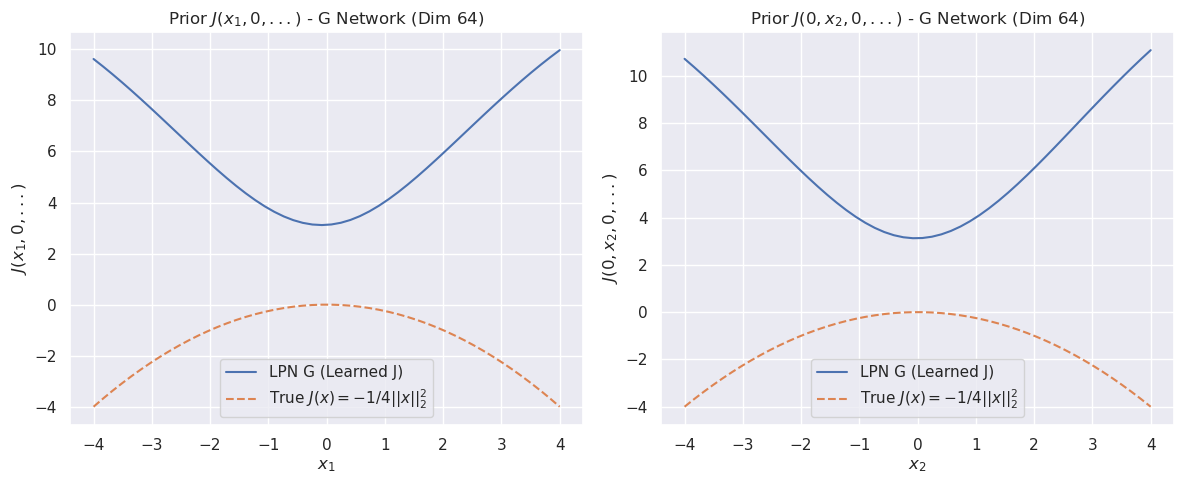

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from G(x) Network ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN G (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - G Network (Dim {dim})")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN G (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - G Network (Dim {dim})")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [12]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l1.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 341.4702453613281


iteration 0 loss 15.838728904724121


iteration 5000 loss 7.179540634155273


iteration 10000 loss 3.813664674758911


iteration 15000 loss 2.2924277782440186


iteration 20000 loss 1.4400665760040283


iteration 25000 loss 0.9479766488075256


iteration 30000 loss 1.0832802057266235


iteration 35000 loss 0.8393714427947998


iteration 40000 loss 0.8192222714424133


iteration 45000 loss 0.45373183488845825


iteration 50000 loss 0.4745434522628784


iteration 55000 loss 0.7426583766937256


iteration 60000 loss 0.7531845569610596


iteration 65000 loss 0.411346971988678


iteration 70000 loss 0.6832197308540344


iteration 75000 loss 0.6372811198234558


iteration 80000 loss 1.3704569339752197


iteration 85000 loss 1.1244580745697021


iteration 90000 loss 1.500152349472046


iteration 95000 loss 1.185526967048645


iteration 100000 loss 0.5794751644134521


iteration 105000 loss 1.1787354946136475


iteration 110000 loss 0.8856775164604187


iteration 115000 loss 0.4906708002090454


iteration 120000 loss 0.6877047419548035


iteration 125000 loss 0.5499128699302673


iteration 130000 loss 1.0775606632232666


iteration 135000 loss 1.2560955286026


iteration 140000 loss 1.0967270135879517


iteration 145000 loss 0.5051087737083435


iteration 150000 loss 0.9899958968162537


iteration 155000 loss 0.714017927646637


iteration 160000 loss 2.1644344329833984


iteration 165000 loss 0.9329132437705994


iteration 170000 loss 1.1478724479675293


iteration 175000 loss 0.72963547706604


iteration 180000 loss 0.8939798474311829


iteration 185000 loss 0.5569078326225281


iteration 190000 loss 0.7668688297271729


iteration 195000 loss 0.39111146330833435


iteration 200000 loss 1.3046448230743408


iteration 205000 loss 0.7447665929794312


iteration 210000 loss 0.7486705183982849


iteration 215000 loss 1.1788817644119263


iteration 220000 loss 0.5013625621795654


iteration 225000 loss 1.1078652143478394


iteration 230000 loss 0.5525838732719421


iteration 235000 loss 0.8433351516723633


iteration 240000 loss 0.6053308248519897


iteration 245000 loss 1.1334201097488403


iteration 250000 loss 0.7436832189559937


iteration 255000 loss 1.293880581855774


iteration 260000 loss 1.2630959749221802


iteration 265000 loss 0.4797675609588623


iteration 270000 loss 0.9291103482246399


iteration 275000 loss 1.313273310661316


iteration 280000 loss 0.27372294664382935


iteration 285000 loss 0.30884769558906555


iteration 290000 loss 1.2143422365188599


iteration 295000 loss 0.37649020552635193


iteration 300000 loss 0.3370302617549896


iteration 305000 loss 0.34595322608947754


iteration 310000 loss 1.7456876039505005


iteration 315000 loss 0.6537891626358032


iteration 320000 loss 0.4924519956111908


iteration 325000 loss 0.38861435651779175


iteration 330000 loss 1.2904826402664185


iteration 335000 loss 0.4915257692337036


iteration 340000 loss 0.7933862805366516


iteration 345000 loss 1.224348545074463


iteration 350000 loss 0.44185584783554077


iteration 355000 loss 1.3226220607757568


iteration 360000 loss 0.4969657063484192


iteration 365000 loss 1.2837210893630981


iteration 370000 loss 1.056172251701355


iteration 375000 loss 0.37941139936447144


iteration 380000 loss 0.953349769115448


iteration 385000 loss 0.4442361295223236


iteration 390000 loss 0.21486647427082062


iteration 395000 loss 0.4454558491706848


iteration 400000 loss 1.1502339839935303


iteration 405000 loss 1.4222828149795532


iteration 410000 loss 0.47596898674964905


iteration 415000 loss 1.0261132717132568


iteration 420000 loss 0.9233447313308716


iteration 425000 loss 1.0265487432479858


iteration 430000 loss 0.7216710448265076


iteration 435000 loss 0.6213955283164978


iteration 440000 loss 1.0964058637619019


iteration 445000 loss 0.4058783948421478


iteration 450000 loss 0.925868034362793


iteration 455000 loss 1.1811864376068115


iteration 460000 loss 1.36826753616333


iteration 465000 loss 0.41703471541404724


iteration 470000 loss 0.8261584043502808


iteration 475000 loss 0.7230507731437683


iteration 480000 loss 0.37389883399009705


iteration 485000 loss 0.8510107398033142


iteration 490000 loss 0.49549466371536255


iteration 495000 loss 1.143198847770691


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
(50,)


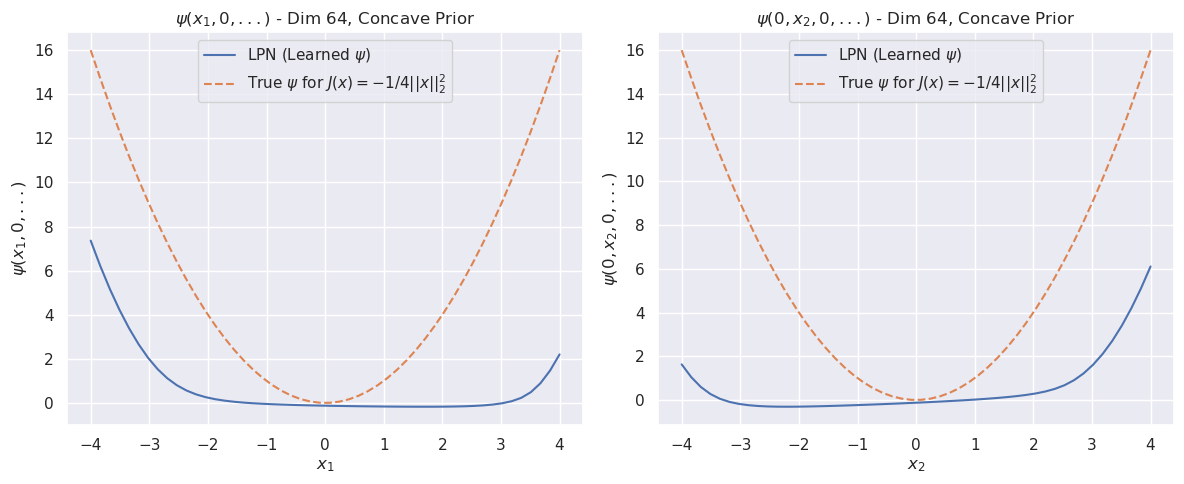

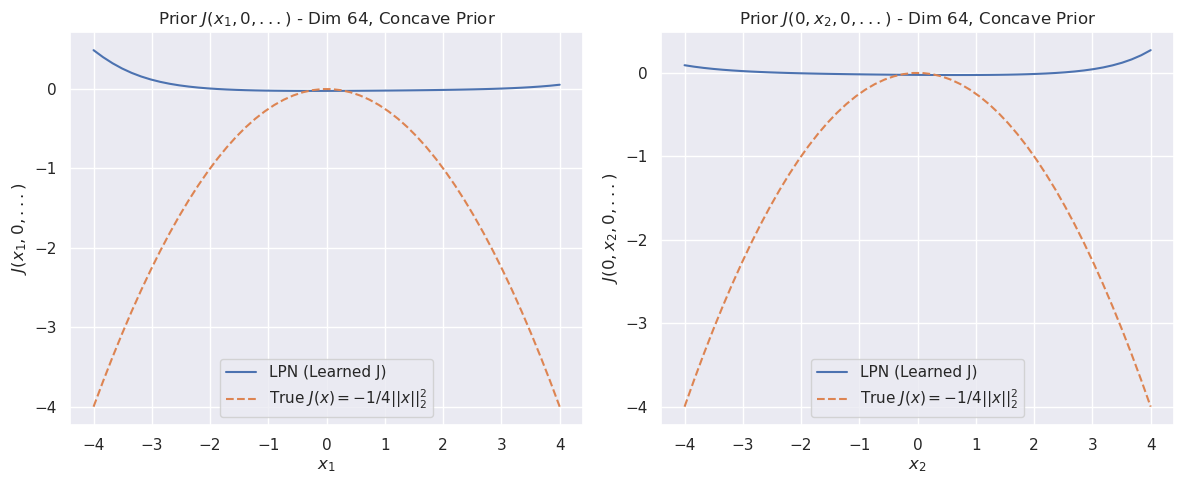

In [13]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)
#evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)

Generated G samples: G_samples_tensor shape torch.Size([20000, 1])

--- Plotting Updated Prior j_hat(y) (Dim=64) ---


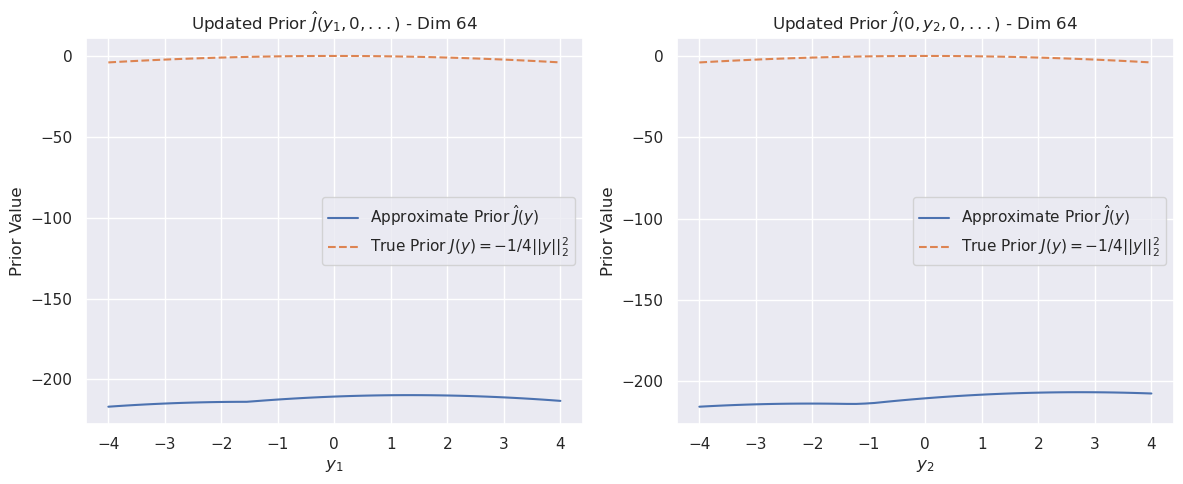

In [14]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = x_j_exp_tensor.clone()
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l1.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l1(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach() 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
    """
    Implements the approximate prior.
    """
    
    # Pre-compute y_k = grad psi(x_k) from the training data
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    y_k_tensor = model(x_k_tensor)
    y_k_np = y_k_tensor.detach().cpu().numpy()
    
    # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
    S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
    S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
    # The constant term simplifies to just S(x_k, 1)
    # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
    #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
    #        = S(x_k, 1)
    constants_k = S_x_k_np  # Shape (K,)
    
    # Term 3: -1/2 * ||x_k - y||^2
    # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
    term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
    # Term 4: 1/4 * ||y - y_k||^2
    # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
    term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

    term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
    all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
    # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
    # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
    # Take the max over K dimension
    j_hat_est = np.max(all_terms, axis=0)
    
    return j_hat_est

def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
    """
    Generates cross-section plots for the prior j_hat(y) from the "Update".
    """
    print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
    xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute true prior J(y)
    y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
    # Compute estimated prior j_hat(y)
    y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
    plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
    plt.grid(True)
    plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
    plt.xlabel('$y_1$')
    plt.ylabel('Prior Value')
    plt.legend()

    if dim > 1:
        y2_0_J_true = prior_true_concave_quad(y2_0_points)
        y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
        plt.subplot(1, 2, 2)
        plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
        plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
        plt.grid(True)
        plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
        plt.xlabel('$y_2$')
        plt.ylabel('Prior Value')
        plt.legend()
        
    plt.tight_layout()
    plt.show()


# We use the original training data 'x_j_exp_np' as our set of x_k points.
#subset_size = 1000 
x_k_subset_np = x_j_exp_np#[:subset_size, :]

plot_updated_prior_J_hat(lpn_model_concave_quad, a_exp, spacing, dim_exp, x_k_subset_np)


In [15]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(iterations_exp_initial):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 48332.3515625


iteration 0 loss 14035.212890625


iteration 5000 loss 138.12818908691406


iteration 10000 loss 40.90824508666992


iteration 15000 loss 10.435690879821777


iteration 20000 loss 1.352888822555542


iteration 25000 loss 0.3715100884437561


iteration 30000 loss 0.1634897142648697


iteration 35000 loss 0.07906806468963623


iteration 40000 loss 0.04207772761583328


iteration 45000 loss 0.023365739732980728


iteration 50000 loss 0.01322205737233162


iteration 55000 loss 0.007681646384298801


iteration 60000 loss 0.004559962544590235


iteration 65000 loss 0.0027422956191003323


iteration 70000 loss 0.0016831292305141687


iteration 75000 loss 0.11327289789915085


iteration 80000 loss 0.0007567758439108729


iteration 85000 loss 0.0004355288401711732


iteration 90000 loss 0.0002844654954969883


iteration 95000 loss 0.00023651089577469975


iteration 100000 loss 0.00013545133697334677


iteration 105000 loss 0.08819395303726196


iteration 110000 loss 0.00025434247800149024


iteration 115000 loss 0.00018642803479451686


iteration 120000 loss 0.00032230804208666086


iteration 125000 loss 0.0013800107408314943


iteration 130000 loss 0.06123222038149834


iteration 135000 loss 3.820691927103326e-05


iteration 140000 loss 3.4795288229361176e-05


iteration 145000 loss 3.283399564679712e-05


iteration 150000 loss 3.339713657624088e-05


iteration 155000 loss 3.334062785143033e-05


iteration 160000 loss 0.9427464604377747


iteration 165000 loss 7.183892012108117e-05


iteration 170000 loss 3.075051790801808e-05


iteration 175000 loss 4.1764873458305374e-05


iteration 180000 loss 2.86041249637492e-05


iteration 185000 loss 2.8393611501087435e-05


iteration 190000 loss 0.007125407457351685


iteration 195000 loss 0.0028836517594754696


iteration 200000 loss 2.7589290766627528e-05


iteration 205000 loss 2.6150455596507527e-05


iteration 210000 loss 0.0027316061314195395


iteration 215000 loss 0.0020669829100370407


iteration 220000 loss 2.8569078494911082e-05


iteration 225000 loss 2.523447255953215e-05


iteration 230000 loss 0.0002021761902142316


iteration 235000 loss 3.5569573810789734e-05


iteration 240000 loss 0.00015117345901671797


iteration 245000 loss 2.3870919903856702e-05


iteration 250000 loss 2.8713197708129883


iteration 255000 loss 7.979314978001639e-05


iteration 260000 loss 2.3331465854425915e-05


iteration 265000 loss 2.878952909668442e-05


iteration 270000 loss 2.705363294808194e-05


iteration 275000 loss 2.2784675820730627e-05


iteration 280000 loss 2.6041938326670788e-05


iteration 285000 loss 7.218799873953685e-05


iteration 290000 loss 3.9557657146360725e-05


iteration 295000 loss 0.0027945442125201225


iteration 300000 loss 0.00017177315021399409


iteration 305000 loss 6.740396202076226e-05


iteration 310000 loss 2.053946809610352e-05


iteration 315000 loss 2.3738220988889225e-05


iteration 320000 loss 3.670145451906137e-05


iteration 325000 loss 2.345518623769749e-05


iteration 330000 loss 2.1450669009936973e-05


iteration 335000 loss 2.375207441218663e-05


iteration 340000 loss 0.00034468749072402716


iteration 345000 loss 3.5373181162867695e-05


iteration 350000 loss 0.08889514207839966


iteration 355000 loss 2.0751347619807348e-05


iteration 360000 loss 2.5414827177883126e-05


iteration 365000 loss 1.9177301510353573e-05


iteration 370000 loss 3.928369187633507e-05


iteration 375000 loss 6.68698558001779e-05


iteration 380000 loss 1.9021194020751864e-05


iteration 385000 loss 3.0256607715273276e-05


iteration 390000 loss 2.065107946691569e-05


iteration 395000 loss 2.0860275981249288e-05


iteration 400000 loss 1.7825759641709737e-05


iteration 405000 loss 4.246629396220669e-05


iteration 410000 loss 2.5580728106433526e-05


iteration 415000 loss 1.9396209609112702e-05


iteration 420000 loss 1.8138738596462645e-05


iteration 425000 loss 2.032017619058024e-05


iteration 430000 loss 1.8545631974120624e-05


iteration 435000 loss 0.4409061372280121


iteration 440000 loss 0.0022333282977342606


iteration 445000 loss 1.7697875591693446e-05


iteration 450000 loss 1.819655517465435e-05


iteration 455000 loss 2.0713328922283836e-05


iteration 460000 loss 1.7774089428712614e-05


iteration 465000 loss 0.00027581886388361454


iteration 470000 loss 2.094667433993891e-05


iteration 475000 loss 1.8008878231048584


iteration 480000 loss 1.9015320503967814e-05


iteration 485000 loss 0.00011491910845506936


iteration 490000 loss 0.17036081850528717


iteration 495000 loss 0.9753589630126953


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


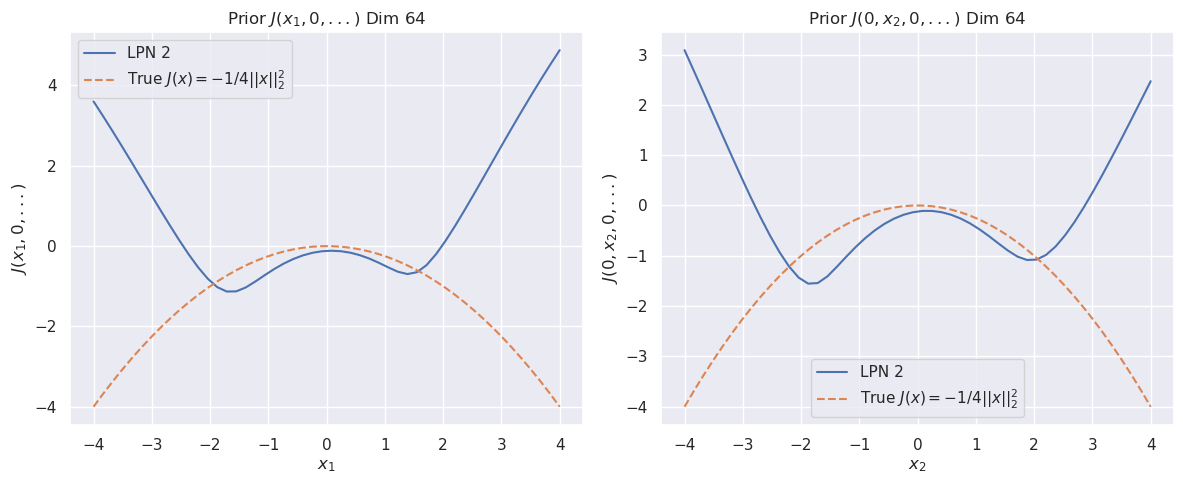

In [16]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)